In [2]:
import dv
import cv2
import aedat
import pickle as pkl
import numpy as np
import ffmpeg
from dv import AedatFile

from mlib import *

In [3]:
aedat4_path = r'D:\Dataset\DVS\dv_data\dvSave-2021_10_20_22_45_37.aedat4'
video_path = r'E:\GitHub\DVS-RGB-Recorder\records\video_calib_1.mp4'
video_time_path = op.splitext(video_path)[0]+'_timestamps.txt'


In [4]:
with open(video_time_path, 'r') as f:
    timeseq = f.readlines()
start = int(float(timeseq[0].strip())*1e6)
end = int(float(timeseq[-1].strip())*1e6)
print(start, end, len(timeseq))

1634784362853138 1634784377824653 433


## Using dv

In [5]:
def filter_events(f, start, end, verbose=False):
    events = np.hstack([packet for packet in f['events'].numpy()])
    # print(events.dtype.names)
    # print(events.shape, events[0].shape, events[0])
    mask = np.logical_and(events['timestamp'] > start, events['timestamp'] < end)
    events_selected = events[mask]
    dvs_start = events_selected[0]['timestamp']
    dvs_end = events_selected[-1]['timestamp']
    valid_flag = events[0]['timestamp']<start and events[-1]['timestamp']>end
    if verbose:
        print(f"Event length: {events_selected.shape}")
        print(f"Data validity of this pair: {valid_flag}")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return events_selected

def filter_frames(f, start, end, verbose=False):
    frames = np.hstack([packet for packet in f['frames']])
    frames_selected = np.array(list(filter(lambda x: x.timestamp > start and x.timestamp < end, frames)))
    dvs_start = frames_selected[0].timestamp
    dvs_end = frames_selected[-1].timestamp
    if verbose:
        print(f"Frame length: {frames_selected.shape}")
        print("Frame attributes: [timestamp, image, size]")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return frames_selected

def filter_imus(f, start, end, verbose=False):
    imus = np.hstack([packet for packet in f['imu']])
    imus_selected = np.array(list(filter(lambda x: x.timestamp > start and x.timestamp < end, imus)))
    dvs_start = imus_selected[0].timestamp
    dvs_end = imus_selected[-1].timestamp
    if verbose:
        print(f"IMU length: {imus_selected.shape}")
        print("IMU attributes: [timestamp, gyroscope, accelerometer, temperature]")
        print(f"DVS start: {dvs_start} μs, RGB start: {start} μs, Delta: {dvs_start-start} μs\nDVS end: {dvs_end} μs, RGB end: {end} μs, Delta: {end-dvs_end} μs")
    return imus_selected

def filter_dvs(f, start, end, verbose=False):
    if verbose:
        print(f.names)
    events_selected = filter_events(f, start, end, verbose=verbose)
    frames_selected = filter_frames(f, start, end, verbose=verbose)
    imus_selected = filter_imus(f, start, end, verbose=verbose)
    return events_selected, frames_selected, imus_selected

def write_dvs(root, events=None, frames=None, imus=None, verbose=False):
    if events is not None:
        event_path = op.join(root, 'events.pkl')
        with open(event_path, 'wb') as f:
            pkl.dump(events, f)
    if frames is not None:
        frame_path = op.join(root, 'frames.pkl')
        with open(frame_path, 'wb') as f:
            pkl.dump(frames, f)
    if imus is not None:
        imu_path = op.join(root, 'imus.pkl')
        with open(imu_path, 'wb') as f:
            pkl.dump(imus, f)
    if verbose:
        print(f"Processed DVS files saved to folder {root}.\n")

def process_dvs_by_rgb(aedat4_path, video_time_path, ret=False, verbose=False):
    new_root = op.splitext(aedat4_path)[0]
    os.makedirs(new_root,exist_ok=True)
    with open(video_time_path, 'r') as f:
        timeseq = f.readlines()
    start = int(float(timeseq[0].strip())*1e6)
    end = int(float(timeseq[-1].strip())*1e6)
    if verbose:
        print(f"※ Now processing {op.split(aedat4_path)[-1]}...")
        print(f"Start time: {start} μs, End time: {end} μs , Frame Num: {len(timeseq)}")

    with AedatFile(aedat4_path) as f:
        events_selected, frames_selected, imus_selected = filter_dvs(f, start, end, verbose=verbose)
        write_dvs(new_root, events=events_selected, frames=frames_selected, imus=imus_selected, verbose=verbose)
    
    if ret:
        return events_selected, frames_selected, imus_selected

In [8]:
video_time_path = op.splitext(video_path)[0]+'_timestamps.txt'
print(video_time_path)

events, frames, imus = process_dvs_by_rgb(aedat4_path, video_time_path, ret=True, verbose=True)

E:\GitHub\DVS-RGB-Recorder\records\video_calib_1_timestamps.txt
※ Now processing dvSave-2021_10_20_22_45_37.aedat4...
Start time: 1634784362853138 μs, End time: 1634784377824653 μs , Frame Num: 433
['events', 'frames', 'imu']
Event length: (4336870,)
Data validity of this pair: True
DVS start: 1634784362853142 μs, RGB start: 1634784362853138 μs, Delta: 4 μs
DVS end: 1634784377824652 μs, RGB end: 1634784377824653 μs, Delta: 1 μs
Frame length: (454,)
Frame attributes: [timestamp, image, size]
DVS start: 1634784362861658 μs, RGB start: 1634784362853138 μs, Delta: 8520 μs
DVS end: 1634784377810658 μs, RGB end: 1634784377824653 μs, Delta: 13995 μs
IMU length: (12167,)
IMU attributes: [timestamp, gyroscope, accelerometer, temperature]
DVS start: 1634784362853177 μs, RGB start: 1634784362853138 μs, Delta: 39 μs
DVS end: 1634784377824239 μs, RGB end: 1634784377824653 μs, Delta: 414 μs
Processed DVS files saved to folder D:\Dataset\DVS\dv_data\dvSave-2021_10_20_22_45_37.



(0, 0) 1634784366491658 (320, 240) 0 0 0 0


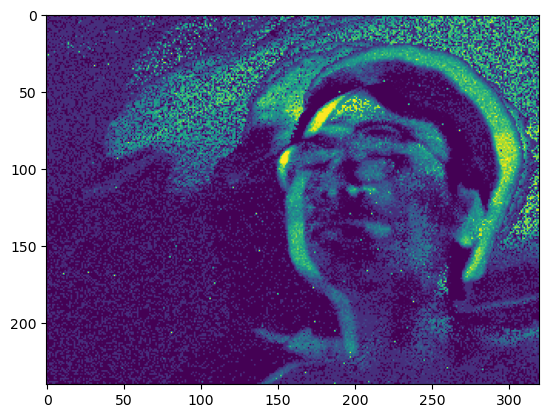

In [9]:
frame = frames[110]
print(frame.position, frame.timestamp, frame.size, frame.timestamp_end_of_exposure, frame.timestamp_end_of_frame, frame.timestamp_start_of_exposure, frame.timestamp_start_of_frame)
mcv.imshow(frame.image)
plt.show()

## Trim a video by time or frame number

In [18]:
out_filename = 'video.mp4'
# ffmpeg.input(video_path).trim(start_frame=10, end_frame=30).output(out_filename).run()
ffmpeg.input(video_path).trim(start=2, end=6).output(out_filename).overwrite_output().run()

(None, None)

## Call Potplayer

In [22]:
import potplayer
potplayer.run(r'D:\MMD\Projects\exp-01-miku-street\video.avi') 

## VMD to JSON

In [18]:
input_files = [
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包3\magunet(Ver2)\蝶モーション.vmd',
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包3\JoJo - Crazy Noisy Bizarre Town [BigYellowAlien]\Crazy Noisy Bizarre Town - Motion [BigYellowAlien].vmd',
    r'D:\MMD\1-动作合集\3-日本歌曲\日本歌曲动作包1\BlueStarモーション\BlueStar（配布用）.vmd',
    ]

In [13]:
from vmd import get_bone_only

In [84]:
bone_state, bone_state_calculator, vam_body, motion_data = get_bone_only(input_files[-2])

Loading motion file...
Calculating motion for: hip
Calculating motion for: abdomen2
Calculating motion for: neck
Calculating motion for: head
Calculating motion for: pelvis
Calculating motion for: lThigh
Calculating motion for: rThigh
Calculating motion for: rKnee
Calculating motion for: lKnee
Calculating motion for: rShoulder
Calculating motion for: lShoulder
Calculating motion for: lArm
Calculating motion for: rArm
Calculating motion for: lElbow
Calculating motion for: rElbow
Calculating motion for: rHand
Calculating motion for: lHand
Calculating motion for: lFoot
Calculating motion for: rFoot


In [85]:
print(bone_state.keys())
parts_length = np.array([(k, len(bone_state[k].keys())) for k in bone_state.keys()])
max_length = max(parts_length[:,1].astype(int))
print("Maximum Length: ", max_length)
_=[print(f"{k}: {v}") for k,v in parts_length]

dict_keys(['hip', 'abdomen2', 'neck', 'head', 'pelvis', 'lThigh', 'rThigh', 'rKnee', 'lKnee', 'rShoulder', 'lShoulder', 'lArm', 'rArm', 'lElbow', 'rElbow', 'rHand', 'lHand', 'lFoot', 'rFoot'])
Maximum Length:  2201
hip: 2201
abdomen2: 2130
neck: 2131
head: 2201
pelvis: 2136
lThigh: 2176
rThigh: 1728
rKnee: 48
lKnee: 48
rShoulder: 2126
lShoulder: 2201
lArm: 2201
rArm: 2192
lElbow: 2111
rElbow: 2096
rHand: 2126
lHand: 2123
lFoot: 2093
rFoot: 2099


In [86]:
key13 = ['head', 'lArm', 'rArm', 'lElbow', 'rElbow', 'lHand', 'rHand', 'lThigh', 'rThigh', 'lKnee', 'rKnee', 'lFoot', 'rFoot']
key14 = ['head', 'neck', 'lArm', 'rArm', 'lElbow', 'rElbow', 'lHand', 'rHand', 'Waist', 'lThigh', 'rThigh', 'lKnee', 'rKnee', 'lFoot', 'rFoot']

In [87]:
part = 'lThigh'
che = bone_state[part]
acts = np.array([get_pos(bone_state[part][k]) for k in range(len(bone_state[part].keys()))])
# print(acts[100:300])
# che

In [89]:
def get_pos(frame):
    pos_keys = ['x', 'y', 'z']
    pos = np.array([frame['pos'][k] for k in pos_keys])
    return pos

all_acts = []
for part in key13:
    acts = np.array([get_pos(bone_state[part][k]) for k in range(len(bone_state[part].keys()))])
    print(acts.shape)
    acts = np.pad(acts, ((0,max_length-acts.shape[0]),(0,0)), mode='edge')
    all_acts.append(acts)
all_acts = np.array(all_acts).transpose(1,0,2)
print(all_acts.shape)

(2201, 3)
(2201, 3)
(2192, 3)
(2111, 3)
(2096, 3)
(2123, 3)
(2126, 3)
(2176, 3)
(1728, 3)
(48, 3)
(48, 3)
(2093, 3)
(2099, 3)
(2201, 13, 3)


In [33]:
class Vmd:

    def __init__(self):
        pass

    @staticmethod
    def from_file(filename, model_name_encode="shift-JIS"):

        with open(filename, "rb") as f:
            from functools import reduce
            array = bytes(reduce(lambda x, y: x+y, list(f)))

        vmd = Vmd()

        VersionInformation = array[:30].decode("ascii")
        if VersionInformation.startswith("Vocaloid Motion Data file"):
            vision = 1
        elif VersionInformation.startswith("Vocaloid Motion Data 0002"):
            vision = 2
        else:
            raise Exception("unknow vision")

        vmd.vision = vision

        vmd.model_name = array[30: 30+10*vision].split(bytes([0]))[0].decode(model_name_encode)
        vmd.bone_keyframe_number = int.from_bytes(array[30+10*vision: 30+10*vision+4], byteorder='little', signed=False)
        vmd.bone_keyframe_record = []
        vmd.morph_keyframe_record = []
        vmd.camera_keyframe_record = []
        vmd.light_keyframe_record = []

        current_index = 34+10 * vision
        import struct
        for i in range(vmd.bone_keyframe_number):
            vmd.bone_keyframe_record.append({
                "BoneName": array[current_index: current_index+15].split(bytes([0]))[0].decode("shift-JIS"),
                "FrameTime": struct.unpack("<I", array[current_index+15: current_index+19])[0],
                "Position": {"x": struct.unpack("<f", array[current_index+19: current_index+23])[0],
                            "y": struct.unpack("<f", array[current_index+23: current_index+27])[0],
                            "z": struct.unpack("<f", array[current_index+27: current_index+31])[0]
                            },
                "Rotation":{"x": struct.unpack("<f", array[current_index+31: current_index+35])[0],
                            "y": struct.unpack("<f", array[current_index+35: current_index+39])[0],
                            "z": struct.unpack("<f", array[current_index+39: current_index+43])[0],
                            "w": struct.unpack("<f", array[current_index+43: current_index+47])[0]
                            },
                "Curve":{
                    "x":(array[current_index+47], array[current_index+51], array[current_index+55], array[current_index+59]),
                    "y":(array[current_index+63], array[current_index+67], array[current_index+71], array[current_index+75]),
                    "z":(array[current_index+79], array[current_index+83], array[current_index+87], array[current_index+91]),
                    "r":(array[current_index+95], array[current_index+99], array[current_index+103], array[current_index+107])
                }


            })
            current_index += 111

        # vmd['MorphKeyFrameNumber'] = int.from_bytes(array[current_index: current_index+4], byteorder="little", signed=False)
        vmd.morph_keyframe_number = int.from_bytes(array[current_index: current_index+4], byteorder="little", signed=False)
        current_index += 4

        for i in range(vmd.morph_keyframe_number):
            vmd.morph_keyframe_record.append({
                'MorphName': array[current_index: current_index+15].split(bytes([0]))[0].decode("shift-JIS"),
                'FrameTime': struct.unpack("<I", array[current_index+15: current_index+19])[0],
                'Weight': struct.unpack("<f", array[current_index+19: current_index+23])[0]
            })
            current_index += 23

        vmd.camera_keyframe_number = int.from_bytes(array[current_index: current_index+4], byteorder="little", signed=False)
        current_index += 4

        for i in range(vmd.camera_keyframe_number):
            vmd.camera_keyframe_record.append({
                'FrameTime': struct.unpack("<I", array[current_index: current_index+4])[0],
                'Distance': struct.unpack("<f", array[current_index+4: current_index+8])[0],
                "Position": {"x": struct.unpack("<f", array[current_index+8: current_index+12])[0],
                            "y": struct.unpack("<f", array[current_index+12: current_index+16])[0],
                            "z": struct.unpack("<f", array[current_index+16: current_index+20])[0]
                            },
                "Rotation":{"x": struct.unpack("<f", array[current_index+20: current_index+24])[0],
                            "y": struct.unpack("<f", array[current_index+24: current_index+28])[0],
                            "z": struct.unpack("<f", array[current_index+28: current_index+32])[0]
                            },
                "Curve": tuple(b for b in array[current_index+32: current_index+36]),
                "ViewAngle": struct.unpack("<I", array[current_index+56: current_index+60])[0],
                "Orthographic": array[60]
            })
            current_index += 61

        vmd.light_keyframe_number = int.from_bytes(array[current_index: current_index+4], byteorder="little", signed=False)
        current_index += 4

        for i in range(vmd.light_keyframe_number):
            vmd.light_keyframe_record.append({
                'FrameTime': struct.unpack("<I", array[current_index: current_index+4])[0],
                'Color': {
                    'r': struct.unpack("<f", array[current_index+4: current_index+8])[0],
                    'g': struct.unpack("<f", array[current_index+8: current_index+12])[0],
                    'b': struct.unpack("<f", array[current_index+12: current_index+16])[0]
                },
                'Direction':{"x": struct.unpack("<f", array[current_index+16: current_index+20])[0],
                            "y": struct.unpack("<f", array[current_index+20: current_index+24])[0],
                            "z": struct.unpack("<f", array[current_index+24: current_index+28])[0]
                            }
            })
            current_index += 28

        vmd_dict = {}
        vmd_dict['Vision'] = vision
        vmd_dict['ModelName'] = vmd.model_name
        vmd_dict['BoneKeyFrameNumber'] = vmd.bone_keyframe_number
        vmd_dict['BoneKeyFrameRecord'] = vmd.bone_keyframe_record
        vmd_dict['MorphKeyFrameNumber'] = vmd.morph_keyframe_number
        vmd_dict['MorphKeyFrameRecord'] = vmd.morph_keyframe_record
        vmd_dict['CameraKeyFrameNumber'] = vmd.camera_keyframe_number
        vmd_dict['CameraKeyFrameRecord'] = vmd.camera_keyframe_record
        vmd_dict['LightKeyFrameNumber'] = vmd.light_keyframe_number
        vmd_dict['LightKeyFrameRecord'] = vmd.light_keyframe_record

        vmd.dict = vmd_dict

        return vmd

In [35]:
if __name__ == '__main__':
    vmd = Vmd.from_file(r'C:\Users\miracleyoo\Downloads\test_f0.vmd', model_name_encode="gb2312")
    from pprint import pprint
    pprint(vmd.dict)

{'BoneKeyFrameNumber': 308,
 'BoneKeyFrameRecord': [{'BoneName': '操作中心',
                         'Curve': {'r': (20, 20, 107, 107),
                                   'x': (20, 20, 107, 107),
                                   'y': (20, 20, 107, 107),
                                   'z': (20, 20, 107, 107)},
                         'FrameTime': 0,
                         'Position': {'x': 0.0, 'y': 0.0, 'z': 0.0},
                         'Rotation': {'w': 1.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}},
                        {'BoneName': '全ての親',
                         'Curve': {'r': (20, 20, 107, 107),
                                   'x': (20, 20, 107, 107),
                                   'y': (20, 20, 107, 107),
                                   'z': (20, 20, 107, 107)},
                         'FrameTime': 0,
                         'Position': {'x': 0.0, 'y': 0.0, 'z': 0.0},
                         'Rotation': {'w': 1.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}},
                    

## Bezier Curve

In [10]:
import bezier
nodes = np.asfortranarray([
    [0.0, 0.25, 0.75, 1.0],
    [0.0, 0.0, 1, 1],
])
curve = bezier.Curve(nodes, degree=3)
curve.evaluate(0.5)

array([[0.5],
       [0.5]])

In [31]:
curve.plot(100)
plt.plot()

[]